## Project 1B

In [378]:
# Initial imports
import os
import requests
from pathlib import Path
import json
import numpy as np
import datetime as dt
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [379]:
# Load .env enviroment variables
load_dotenv()

True

In [380]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    base_url="https://paper-api.alpaca.markets",
    api_version="v2")

In [381]:
# Format current date as ISO format
today = pd.Timestamp("2021-03-31", tz="America/New_York").isoformat()
start_day = pd.Timestamp("2016-03-31", tz="America/New_York").isoformat()
# need to update timeframe to 2016

# Set the tickers
tickers = ["SCHZ", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
ticker_data = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_day,
    end = today,
    limit = 1000
).df

# Preview DataFrame
ticker_data.head()

SCHZ                                        SPY  \
                            open     high     low   close    volume    open   
time                                                                          
2017-04-06 00:00:00-04:00  51.85  51.8500  51.750  51.840  256515.0     NaN   
2017-04-07 00:00:00-04:00  51.91  51.9200  51.680  51.765  302885.0     NaN   
2017-04-10 00:00:00-04:00  51.80  51.8400  51.760  51.810  459968.0     NaN   
2017-04-11 00:00:00-04:00  51.90  51.9653  51.847  51.940  407094.0  234.87   
2017-04-12 00:00:00-04:00  52.00  52.0800  51.950  52.050  443459.0  234.74   

                                                               
                             high     low   close      volume  
time                                                           
2017-04-06 00:00:00-04:00     NaN     NaN     NaN         NaN  
2017-04-07 00:00:00-04:00     NaN     NaN     NaN         NaN  
2017-04-10 00:00:00-04:00     NaN     NaN     NaN         NaN  
2017-04-11 00:00:00-04:00  235.18  233.34  235.04  63951745.0  
2017-04-12 00:00:00-04:00  234.96  233.77  234.10  55338215.0

In [382]:
#Create SCHZ and SPY Dataframe
df_closingprice = pd.DataFrame()
df_closingprice["SCHZ"]= ticker_data["SCHZ"]["close"]
df_closingprice["SPY"]= ticker_data["SPY"]["close"]
df_closingprice.index=df_closingprice.index.date
df_closingprice.head()

,SCHZ,SPY
2017-04-06,51.840,NaN
2017-04-07,51.765,NaN
2017-04-10,51.810,NaN
2017-04-11,51.940,235.04
2017-04-12,52.050,234.10


In [383]:
#Data Cleaning
df_closingprice.isnull().sum()

SCHZ    3
SPY     3
dtype: int64

In [384]:
df_closingprice = df_closingprice.dropna().copy()

In [385]:
df_closingprice.isnull().sum()

SCHZ    0
SPY     0
dtype: int64

In [386]:
df_closingprice.count()

SCHZ    997
SPY     997
dtype: int64

In [387]:
df_closingprice.head()

,SCHZ,SPY
2017-04-11,51.94,235.04
2017-04-12,52.05,234.10
2017-04-13,52.11,232.54
2017-04-17,52.11,234.57
2017-04-18,52.29,233.86


In [388]:
#Assigning weights to Traditional Income (ti) portfolio
ti_spy_percentage = 0.2
ti_schz_percentage = 0.8

traditional_returns = df_closingprice.pct_change()
traditional_returns = traditional_returns.dropna().copy()
weights_ti = [ti_spy_percentage, ti_schz_percentage]
ti_portfolio_weighted = traditional_returns.dot(weights_ti)
ti_portfolio_weighted.head()

2017-04-12   -0.002776
2017-04-13   -0.005101
2017-04-17    0.006984
2017-04-18   -0.001731
2017-04-19   -0.001602
dtype: float64

<AxesSubplot:title={'center':'Income Portfolio Cumulative Returns'}>

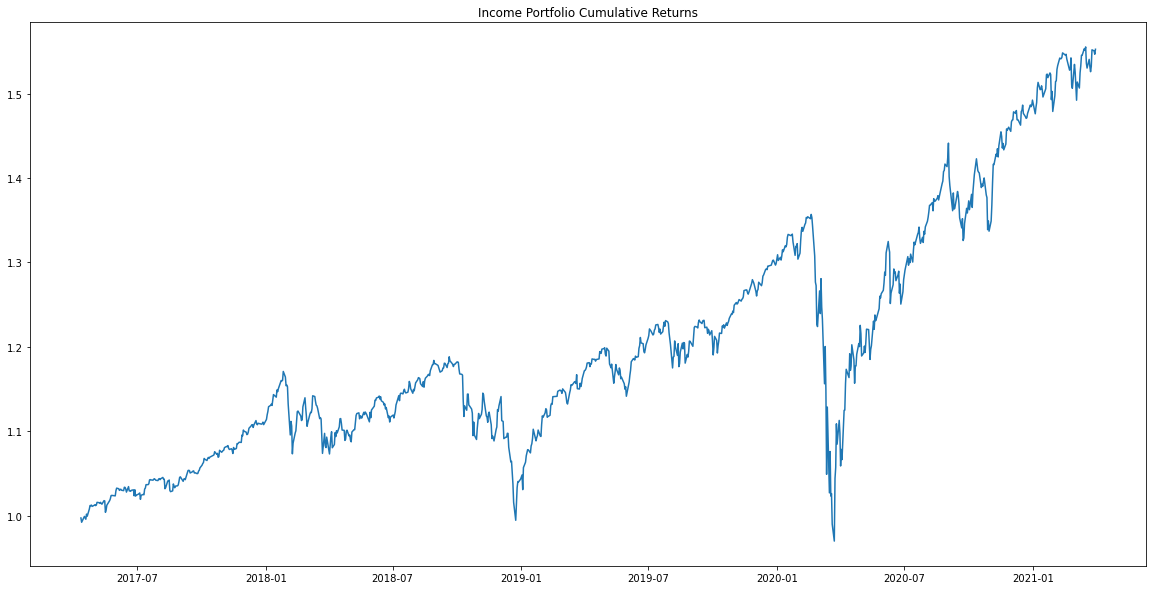

In [389]:
#Calculate and plot combined returns
ti_portfolio_cumulative_returns = (1 + ti_portfolio_weighted).cumprod()
ti_portfolio_cumulative_returns.plot(figsize=(20,10), title = "Income Portfolio Cumulative Returns")

In [390]:
#Retrieve Crypto (BTC) Prices and create Dataframe
btc_prices_csv = Path("resources/btc_usd_5_year_historical.csv")
btc_prices = pd.read_csv(
    btc_prices_csv, index_col="Date", infer_datetime_format=True, parse_dates=True)
btc_prices = btc_prices.sort_index()
btc_prices.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-04-03,421.173004,421.579987,419.696991,420.903992,420.903992,38053700.0
2016-04-04,421.299011,422.342987,419.601013,421.444000,421.444000,50634300.0
2016-04-05,421.016998,424.256989,420.614014,424.029999,424.029999,60718000.0
2016-04-06,424.283997,424.527008,422.729004,423.412994,423.412994,59091000.0
2016-04-07,423.619995,423.657013,420.518005,422.744995,422.744995,57858600.0


In [391]:
#Isolate Crypto close price
btc_closingprice = pd.DataFrame()
btc_closingprice = btc_prices["Close"]
btc_closingprice.index= btc_closingprice.index.date
btc_closingprice.head()

2016-04-03    420.903992
2016-04-04    421.444000
2016-04-05    424.029999
2016-04-06    423.412994
2016-04-07    422.744995
Name: Close, dtype: float64

In [392]:
#Combine Traditional Income portfolio with Crypto to create Hybrid Portfolio
hybrid_close = pd.concat([df_closingprice, btc_closingprice], axis="columns", join="inner")
hybrid_close = hybrid_close.rename(columns={"Close": "Crypto"})
hybrid_close.head()

,SCHZ,SPY,Crypto
2017-04-11,51.94,235.04,1205.010010
2017-04-12,52.05,234.10,1200.369995
2017-04-13,52.11,232.54,1169.280029
2017-04-17,52.11,234.57,1193.910034
2017-04-18,52.29,233.86,1211.670044


In [393]:
#Calculating daily returns on Hybrid Portfolio
hybrid_returns = hybrid_close.pct_change()
hybrid_returns = hybrid_returns.dropna().copy()
hybrid_returns.head()

,SCHZ,SPY,Crypto
2017-04-12,0.002118,-0.003999,-0.003851
2017-04-13,0.001153,-0.006664,-0.025900
2017-04-17,0.000000,0.008730,0.021064
2017-04-18,0.003454,-0.003027,0.014876
2017-04-19,-0.001339,-0.001668,-0.001139


In [394]:
# Adding 5% of Crypto (BTC) by reducing Bonds and Stocks proportionally
hi_btc_percentage = 0.02
hi_schz_percentage = ti_schz_percentage - (ti_schz_percentage * hi_btc_percentage)
hi_spy_percentage = ti_spy_percentage - (ti_spy_percentage * hi_btc_percentage)

#Assigning weights to Hybrid Income (hi) Portfolio
weights_hi = [hi_schz_percentage, hi_spy_percentage, hi_btc_percentage]
hi_portfolio_weighted = hybrid_returns.dot(weights_hi)
hi_portfolio_weighted.head()

2017-04-12    0.000799
2017-04-13   -0.000920
2017-04-17    0.002132
2017-04-18    0.002412
2017-04-19   -0.001399
dtype: float64

In [395]:
print(hi_schz_percentage)

0.784


<AxesSubplot:title={'center':'Hybrid Income Portfolio Cumulative Returns'}>

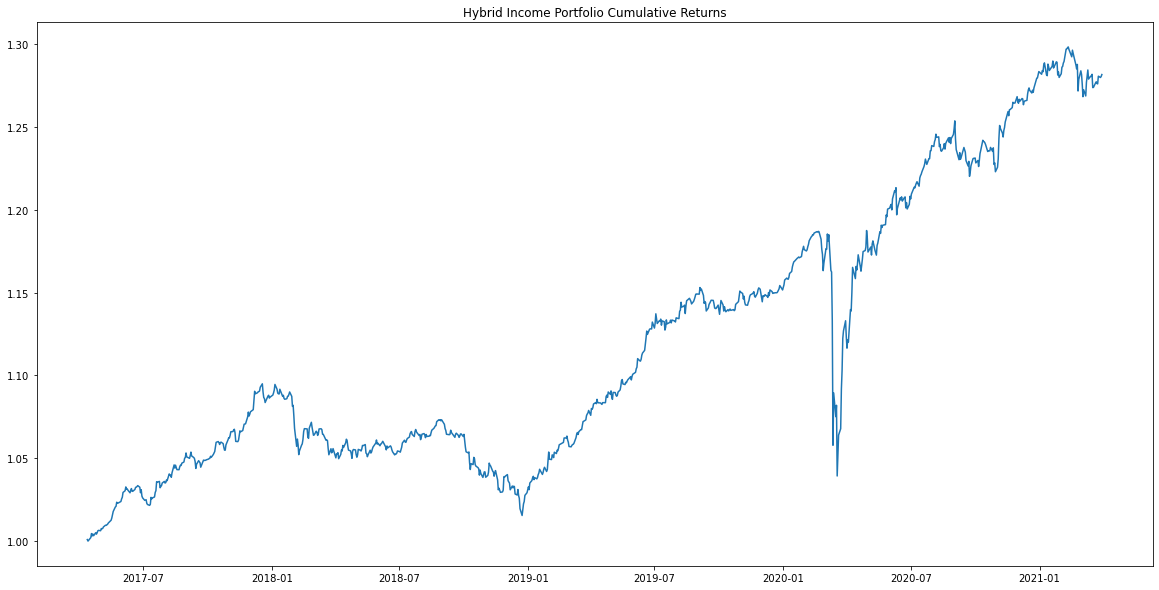

In [396]:
#Calculate and plot Hybrid Income Portfolio returns
hi_cumulative_hybrid_returns = (1 + hi_portfolio_weighted).cumprod()
hi_cumulative_hybrid_returns.plot(figsize=(20,10), title = "Hybrid Income Portfolio Cumulative Returns")

In [397]:
#Combined Traditional Income and Hybrid Income dataframes
thi_cumulative_returns = pd.concat([ti_portfolio_cumulative_returns, hi_cumulative_hybrid_returns], axis="columns", join="inner")
columns = ["Traditional Income", "Hybrid Income"]
thi_cumulative_returns.columns = columns
thi_cumulative_returns.tail()

,Traditional Income,Hybrid Income
2021-03-25,1.532131,1.276063
2021-03-26,1.551799,1.280730
2021-03-29,1.550534,1.279945
2021-03-30,1.546528,1.280524
2021-03-31,1.552426,1.281721


<AxesSubplot:title={'center':'Traditional vs. Hybrid Income Portfolio Cumulative Returns'}>

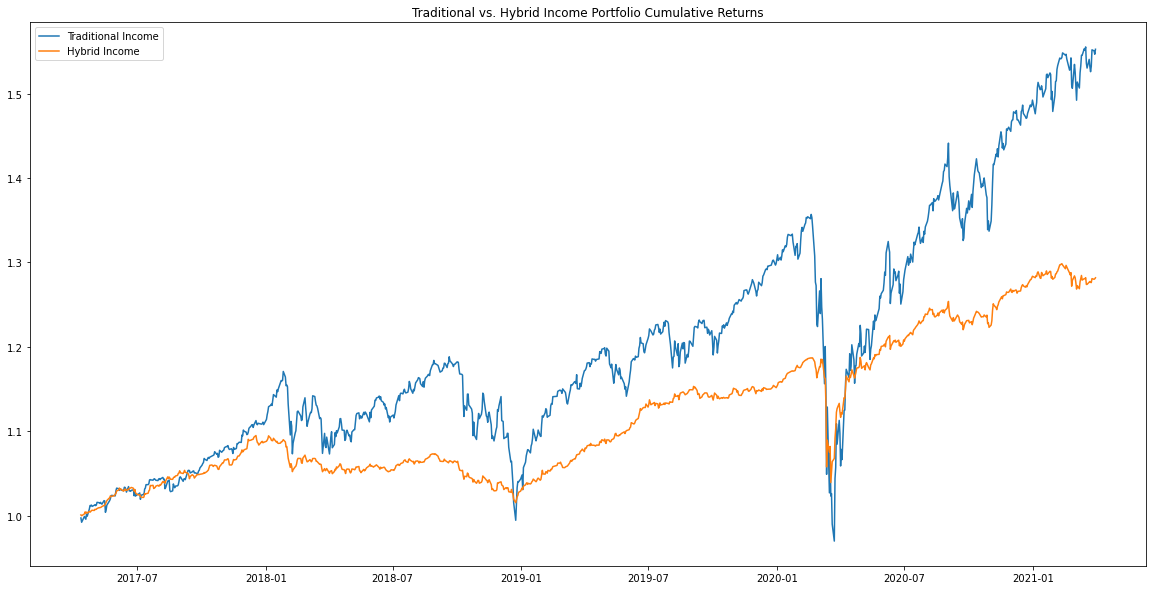

In [398]:
#Plot combined Income Dataframes
thi_cumulative_returns.plot(figsize=(20,10), title = "Traditional vs. Hybrid Income Portfolio Cumulative Returns")

In [399]:
#Combine Traditional and Hybrid Income Dataframes
thi_returns = pd.concat([ti_portfolio_weighted, hi_portfolio_weighted], axis="columns", join="inner")
columns = ["Traditional Income", "Hybrid Income"]
thi_returns.columns = columns
thi_returns.head()

,Traditional Income,Hybrid Income
2017-04-12,-0.002776,0.000799
2017-04-13,-0.005101,-0.000920
2017-04-17,0.006984,0.002132
2017-04-18,-0.001731,0.002412
2017-04-19,-0.001602,-0.001399


In [400]:
#Calculate Sharpe Ratios on Traditional and Hybrid Income Portfolios
income_sharpe_ratios = (thi_returns.mean() * 252) / (thi_returns.std() * np.sqrt(252))
income_sharpe_ratios

Traditional Income    0.750284
Hybrid Income         1.021897
dtype: float64

<AxesSubplot:title={'center':'Sharpe Ratios'}>

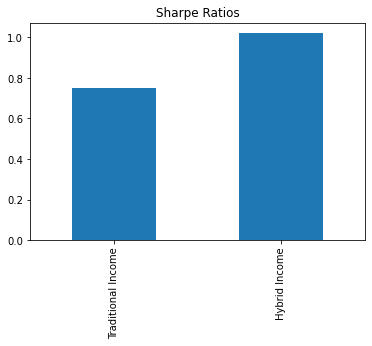

In [401]:
# Visualize the sharpe ratios as a bar plot
income_sharpe_ratios.plot(kind="bar", title="Sharpe Ratios")

## Need to add summary statements

## 

### Start of Balanced Portfolio Section

In [402]:
#Assigning weights to Traditional Balanced (tb) portfolio
balanced_spy_percentage = 0.5
balanced_schz_percentage = 0.5
weights_tb = [balanced_spy_percentage, balanced_schz_percentage]
balanced_portfolio_weighted = traditional_returns.dot(weights_tb)
balanced_portfolio_weighted.head()

2017-04-12   -0.000941
2017-04-13   -0.002756
2017-04-17    0.004365
2017-04-18    0.000214
2017-04-19   -0.001503
dtype: float64

<AxesSubplot:title={'center':'Traditional Balanced Portfolio Cumulative Returns'}>

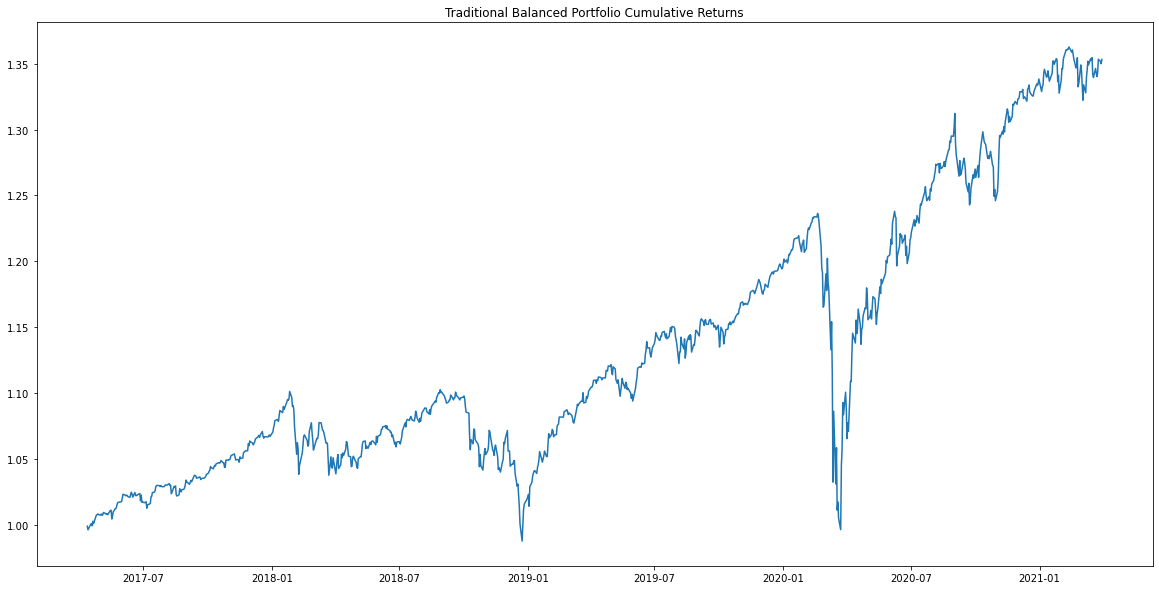

In [403]:
#Calculate and plot Traditional Balanced Portfolio returns
balanced_cumulative_traditional_returns = (1 + balanced_portfolio_weighted).cumprod()
balanced_cumulative_traditional_returns.plot(figsize=(20,10), title = "Traditional Balanced Portfolio Cumulative Returns")

In [404]:
# Adding 10% of Crypto (BTC) by reducing Bonds and Stocks proportionally
balanced_btc_percentage = 0.04
balanced_schz_percentage_2 = balanced_schz_percentage - (balanced_schz_percentage * balanced_btc_percentage)
balanced_spy_percentage_2 = balanced_spy_percentage - (balanced_spy_percentage * balanced_btc_percentage)
weights_hb = [balanced_schz_percentage_2, balanced_spy_percentage_2, balanced_btc_percentage]
balanced_hybrid_portfolio_weighted = hybrid_returns.dot(weights_hb)
balanced_hybrid_portfolio_weighted.head()

2017-04-12   -0.001057
2017-04-13   -0.003681
2017-04-17    0.005033
2017-04-18    0.000800
2017-04-19   -0.001489
dtype: float64

<AxesSubplot:title={'center':'Hybrid Balanced Cumulative Portfolio Returns'}>

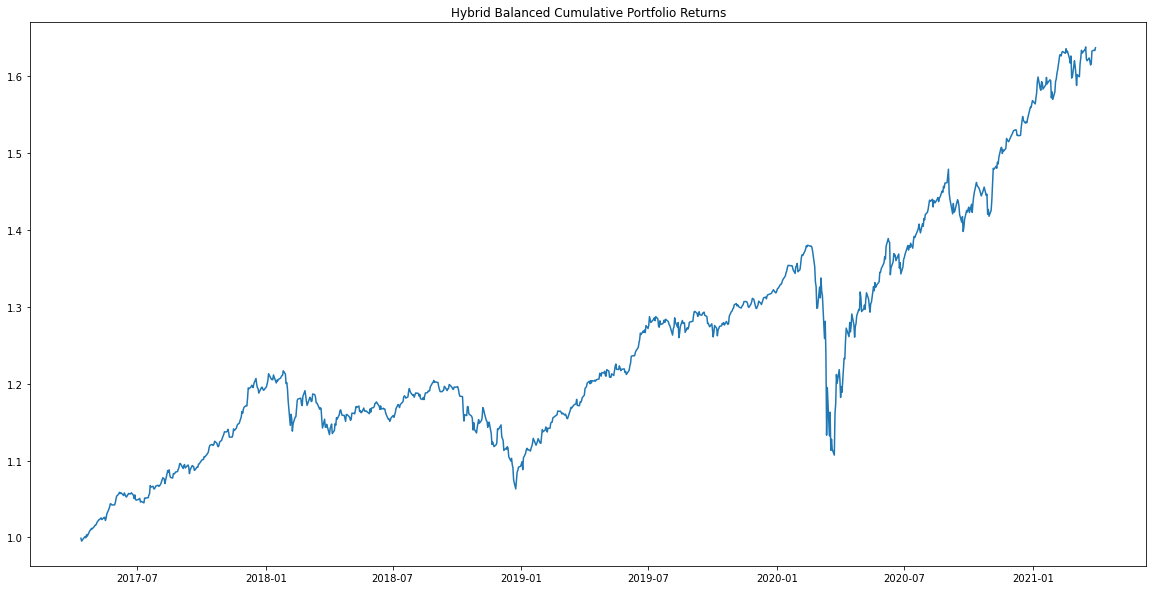

In [405]:
#Calculate and plot Hybrid Balanced Portfolio returns
balanced_cumulative_hybrid_returns = (1 + balanced_hybrid_portfolio_weighted).cumprod()
balanced_cumulative_hybrid_returns.plot(figsize=(20,10), title = "Hybrid Balanced Cumulative Portfolio Returns")

In [406]:
#Combined Traditional and Hybrid Balanced Dataframes
balanced_hybrid_traditional_cumulative_returns = pd.concat([balanced_cumulative_traditional_returns, balanced_cumulative_hybrid_returns], axis="columns", join="inner")
columns = ["Traditional Balanced", "Hybrid Balanced"]
balanced_hybrid_traditional_cumulative_returns.columns = columns
balanced_hybrid_traditional_cumulative_returns.head()

,Traditional Balanced,Hybrid Balanced
2017-04-12,0.999059,0.998943
2017-04-13,0.996306,0.995265
2017-04-17,1.000655,1.000274
2017-04-18,1.000869,1.001075
2017-04-19,0.999364,0.999585


<AxesSubplot:title={'center':'Traditional vs. Hybrid Balanced Portfolio Cumulative Returns'}>

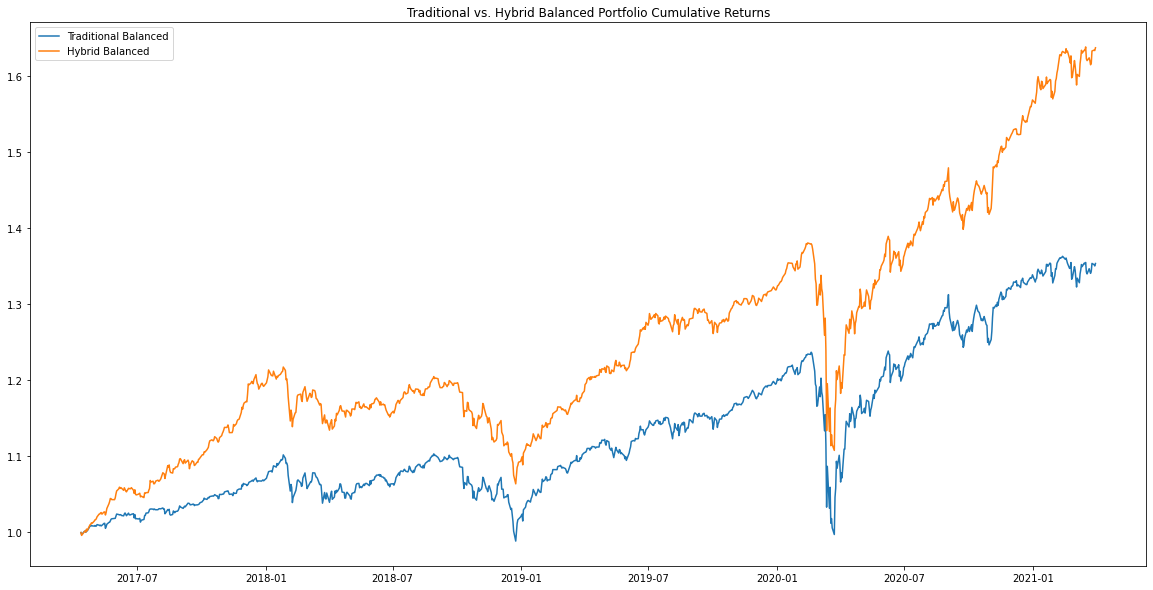

In [407]:
#Plot combined Balanced Dataframes
balanced_hybrid_traditional_cumulative_returns.plot(figsize=(20,10), title = "Traditional vs. Hybrid Balanced Portfolio Cumulative Returns")

### Need to update Sharpe Ratios for Balanced Portfolio

In [408]:
#Combine Traditional and Hybrid Income Weighted Daily Returns Dataframes
thb_returns = pd.concat([balanced_portfolio_weighted, balanced_hybrid_portfolio_weighted], axis="columns", join="inner")
columns = ["Traditional Balanced", "Hybrid Balanced"]
thb_returns.columns = columns
thb_returns.head()

,Traditional Balanced,Hybrid Balanced
2017-04-12,-0.000941,-0.001057
2017-04-13,-0.002756,-0.003681
2017-04-17,0.004365,0.005033
2017-04-18,0.000214,0.000800
2017-04-19,-0.001503,-0.001489


In [409]:
#Calculate Sharpe Ratios on Traditional and Hybrid Balanced Portfolios
balanced_sharpe_ratios = ((thb_returns.mean()) * 252) / (thb_returns.std() * np.sqrt(252))
balanced_sharpe_ratios

Traditional Balanced    0.762637
Hybrid Balanced         1.147404
dtype: float64

<AxesSubplot:title={'center':'Sharpe Ratios'}>

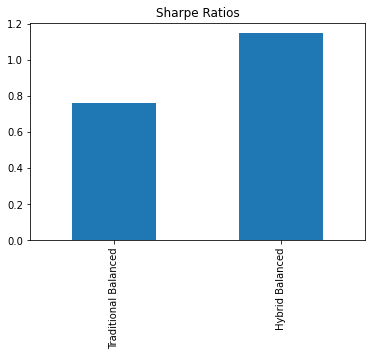

In [410]:
balanced_sharpe_ratios.plot(kind="bar", title="Sharpe Ratios")

### Need to add summary statements

### Growth Section Below

In [411]:
#Assigning weights to Traditional Growth (tg) portfolio
tg_spy_percentage = 0.8
tg_schz_percentage = 0.2
weights_tg = [tg_spy_percentage, tg_schz_percentage]
tg_portfolio_weighted = traditional_returns.dot(weights_tg)
tg_portfolio_weighted.head()

2017-04-12    0.000894
2017-04-13   -0.000411
2017-04-17    0.001746
2017-04-18    0.002158
2017-04-19   -0.001404
dtype: float64

<AxesSubplot:title={'center':'Growth Portfolio Cumulative Returns'}>

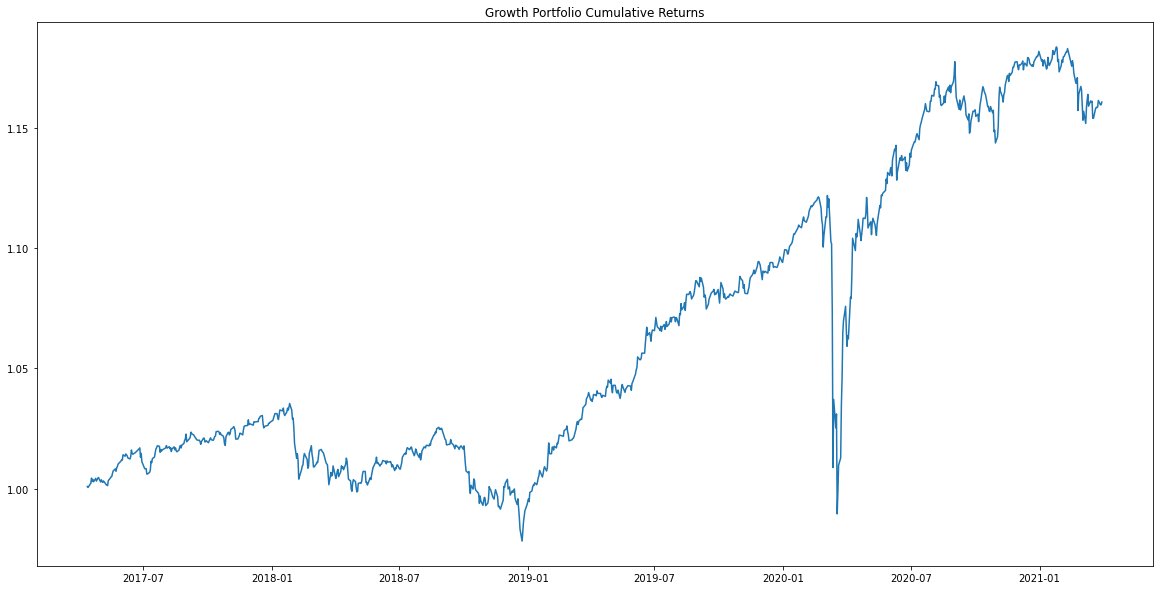

In [412]:
#Calculate and plot combined returns
tg_portfolio_cumulative_returns = (1 + tg_portfolio_weighted).cumprod()
tg_portfolio_cumulative_returns.plot(figsize=(20,10), title = "Growth Portfolio Cumulative Returns")

In [413]:
# Adding 15% of Crypto (BTC) by reducing Bonds and Stocks proportionally
hg_btc_percentage = 0.06
hg_schz_percentage = tg_schz_percentage - (tg_schz_percentage * hg_btc_percentage)
hg_spy_percentage = tg_spy_percentage - (tg_spy_percentage * hg_btc_percentage)

#Assigning weights to Hybrid Growth (hg) Portfolio
weights_hg = [hg_schz_percentage, hg_spy_percentage, hg_btc_percentage]
hg_portfolio_weighted = hybrid_returns.dot(weights_hg)
hg_portfolio_weighted.head()

2017-04-12   -0.002840
2017-04-13   -0.006348
2017-04-17    0.007829
2017-04-18   -0.000734
2017-04-19   -0.001574
dtype: float64

<AxesSubplot:title={'center':'Hybrid Growth Portfolio Cumulative Returns'}>

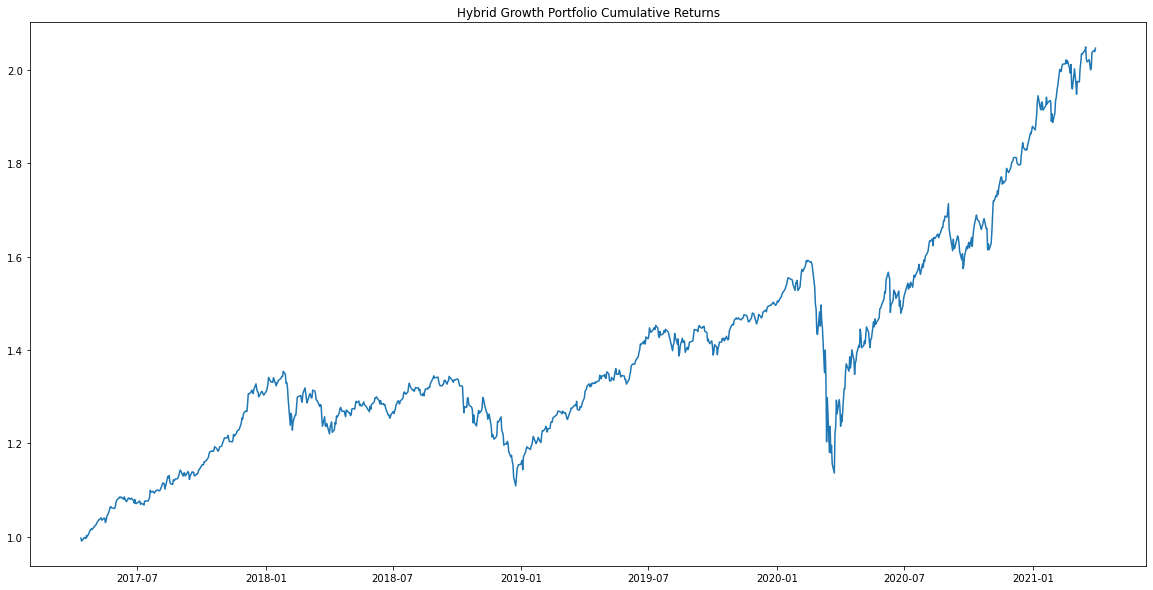

In [414]:
#Calculate and plot Hybrid Growth Portfolio returns
hg_cumulative_returns = (1 + hg_portfolio_weighted).cumprod()
hg_cumulative_returns.plot(figsize=(20,10), title = "Hybrid Growth Portfolio Cumulative Returns")

In [415]:
#Combined Traditional Income and Hybrid Income dataframes
thg_cumulative_returns = pd.concat([tg_portfolio_cumulative_returns, hg_cumulative_returns], axis="columns", join="inner")
columns = ["Traditional Growth", "Hybrid Growth"]
thg_cumulative_returns.columns = columns
thg_cumulative_returns.head()

,Traditional Growth,Hybrid Growth
2017-04-12,1.000894,0.997160
2017-04-13,1.000483,0.990829
2017-04-17,1.002230,0.998586
2017-04-18,1.004393,0.997853
2017-04-19,1.002982,0.996282


<AxesSubplot:title={'center':'Traditional vs. Hybrid Growth Portfolio Cumulative Returns'}>

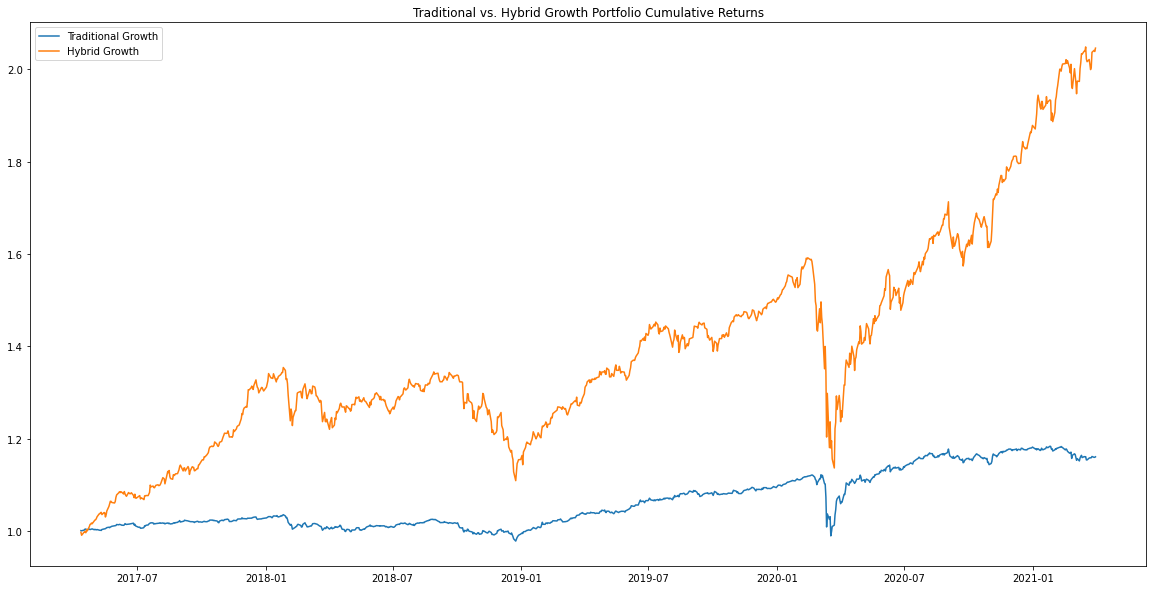

In [416]:
#Plot combined Income Dataframes
thg_cumulative_returns.plot(figsize=(20,10), title = "Traditional vs. Hybrid Growth Portfolio Cumulative Returns")

In [417]:
#Combine Traditional and Hybrid Income Weighted Daily Returns Dataframes
thg_returns = pd.concat([tg_portfolio_weighted, hg_portfolio_weighted], axis="columns", join="inner")
columns = ["Traditional Growth", "Hybrid Growth"]
thg_returns.columns = columns
thg_returns.head()

,Traditional Growth,Hybrid Growth
2017-04-12,0.000894,-0.002840
2017-04-13,-0.000411,-0.006348
2017-04-17,0.001746,0.007829
2017-04-18,0.002158,-0.000734
2017-04-19,-0.001404,-0.001574


In [418]:
#Calculate Sharpe Ratios on Traditional and Hybrid Income Portfolios
thg_sharpe_ratios = ((thg_returns.mean()) * 252) / (thg_returns.std() * np.sqrt(252))
thg_sharpe_ratios

Traditional Growth    0.665802
Hybrid Growth         1.137951
dtype: float64

<AxesSubplot:title={'center':'Sharpe Ratios'}>

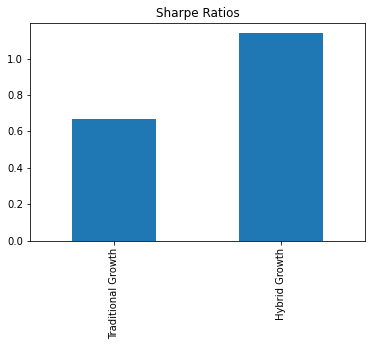

In [419]:
# Visualize the sharpe ratios as a bar plot
thg_sharpe_ratios.plot(kind="bar", title="Sharpe Ratios")

## Need to add summary statements